## Predictive Modeling (GMS) -Day By Day From Best Model

### Summary of Previous Stage (see Notebook 3; Preprocessing_Training_CompletionRangeFiltered)

Note that for this version, puzzles from the first solve period (2018) have been removed due to the volatility of times in that solve period, while the GMS presumably "learned the ropes" of digital solving. In this version, one puzzle day is modeled at a time. 

This notebook is for generating feature-subtraction variants

### High-Level Overview of Modeling

Four regression models are evaluated presently, across the entire sample of 15x15 puzzles solved by the GMS. First is simply a Linear Regression Model. The subsequent three models are decision tree models: Random Forest, Gradient Boosting Regressor and HistGradient Boosting Regressor. The latter is an ensemble machine learning algorithm that is very fast (relative to standard gradient boosting models), and performs well on heterogenous data sets. Boosting, generally, refers to a class of ensemble learning algorithms that add tree models to an ensemble sequentially. 

### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
#from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load and Filter Data

Filtering parameters identical to in dummy/simple modeling stage. 

In [2]:
# Ths is the file and analysis data range used for the main clay court analysis
#Note that 2018 was already filtered out prior to the data import here, though it was kept in to accrue retrospective stats on solver and constructor performance for puzzles 2019 and later
#df = pd.read_csv('../data/df_for_modeling.csv')
#df.head()

In [544]:
# Ths is the file and analysis data range used for the main clay court analysis
#Note that 2018 was already filtered out prior to the data import here, though it was kept in to accrue retrospective stats on solver and constructor performance for puzzles 2019 and later
#Use only for no decay weighting subtraction model
df = pd.read_csv('../data/df_for_modeling_no_decay_weighting.csv')
#df.head()

In [545]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   P_Date                                 1860 non-null   object 
 1   P_Date_str                             1860 non-null   object 
 2   GMS_Completed                          1860 non-null   int64  
 3   DOW                                    1860 non-null   object 
 4   DOW_num                                1860 non-null   float64
 5   GMST(m)                                1860 non-null   float64
 6   GMS_pds_l10_dw                         1860 non-null   float64
 7   GMS_pds_l25_dw                         1860 non-null   float64
 8   GMS_pds_l50_dw                         1860 non-null   float64
 9   GMS_pds_l10_stdev                      1860 non-null   float64
 10  GMS_pds_l25_stdev                      1860 non-null   float64
 11  GMS_

In [730]:
# Drop some columns that we don't want/need for modeling
df_filter = df.copy()
df_filter.drop(['P_Date','P_Date_str', 'GMS_Completed', 'DOW', 'GMST_Diff%_from_GMS_pds_l10_dw','GMS_per_constr_past_diff_from_RPB_ct','Constructors','overall_day_mean_GMST(m)','Uniclue','Duplicate_Answers','Unchecked_Sq','Quantum'],inplace=True,axis=1)

In [731]:
#Move target feature to the front
col = df_filter.pop('GMST(m)')
df_filter.insert(0, col.name, col)

In [732]:
#Found a bad value in first modeling iteration, so correcting here
# df["Duplicate_Answers"].unique()
# df["Uniclue"].unique()
# df["Unchecked_Sq"].unique()
# df["Quantum"].unique()

In [733]:
# Remove Sunday
df_filter = (df_filter.loc[(df_filter['DOW_num'] != 1)]) # Sun

In [734]:
# Drop feature or set of features for the particular subtraction model
# Drop some columns that we don't want/need for modeling
#df_filter.drop(['GMS_pds_l10_dw','GMS_pds_l10_stdev'],inplace=True,axis=1) #no short-term performance
df_filter.drop(['GMS_pds_l25_dw','GMS_pds_l25_stdev'],inplace=True,axis=1) #no long-term performance
df_filter.drop(['GMS_pds_l50_dw','GMS_pds_l50_stdev'],inplace=True,axis=1) #no long-term performance
#df_filter.drop(['DOW_num'],inplace=True,axis=1) #no long-term performance
#df_filter.drop(['GMS_per_constr_avg_past_diff_from_RPB'],inplace=True,axis=1) #no constructor past performance 
#df_filter.drop(['Words','AWL','Blocks','Cheater_Squares','Circle_Count','Open_Squares','Shade_Count','Stacks','Unusual_Sym'],inplace=True,axis=1) #no grid features
#df_filter.drop(['Cross_Ref_Clues','Duplicate_Clues','Wordplay'],inplace=True,axis=1) #no clue features
#df_filter.drop(['Black_Square_Fill','Day_Freshness%','FITB','Freshness_Factor','Outside_Grid','Overall_Freshness%','Rebus_Unique','Rebus_Count','Scrabble_Avg','Scrabble_Illegal','Scrabble_Score','Unique_Answers','Unused_Letters'],inplace=True,axis=1) #no answer features
#df_filter.drop(['GMS_pds_l10_dw','GMS_pds_l10_stdev','GMS_pds_l25_dw','GMS_pds_l25_stdev','GMS_per_constr_avg_past_diff_from_RPB'],inplace=True,axis=1) #no past performance

In [735]:
#Deep copy of this df_filter that is now pared down to just the predictive features and the target feature itself 
# All features are derived from data available prior to any given puzzle being predicted on. No data leakage!
df_model1 = df_filter.copy()

In [736]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1595 entries, 0 to 1859
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   GMST(m)                                1595 non-null   float64
 1   DOW_num                                1595 non-null   float64
 2   GMS_pds_l10_dw                         1595 non-null   float64
 3   GMS_pds_l10_stdev                      1595 non-null   float64
 4   GMS_per_constr_avg_past_diff_from_RPB  1100 non-null   float64
 5   GMS_pds_prior_solves_ct                1595 non-null   float64
 6   GMS_npds_prior_solves_ct               1595 non-null   float64
 7   Words                                  1595 non-null   int64  
 8   Blocks                                 1595 non-null   int64  
 9   Unused_Letters                         1595 non-null   int64  
 10  Stacks                                 1595 non-null   int64  
 11  Uniq

In [737]:
#df_model1.to_csv('../data/df_model1.csv', index=False)

### Data Split for Modeling

Identical split as for dummy/simple modeling

In [738]:
len(df_model1) * .75, len(df_model1) * .25

(1196.25, 398.75)

In [739]:
#Replicates EXACT train-test split from dummy and simpler modeling
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='GMST(m)'), 
                                                    df_model1['GMST(m)'], test_size=0.25, 
                                                    random_state=47)

In [740]:
y_train.shape, y_test.shape

((1196,), (399,))

In [741]:
y_train

754      5.966667
123      7.950000
948     11.516667
992      5.916667
275     28.633333
          ...    
806     16.033333
681     14.350000
1502    11.450000
381      9.900000
1352    23.200000
Name: GMST(m), Length: 1196, dtype: float64

In [742]:
X_train.shape, X_test.shape

((1196, 31), (399, 31))

In [743]:
# Get training set mean to normalize the error to, as this will change with different puzzle day subtractions
#Target feature (GMST(m)) training set mean
train_mean = y_train.mean()
train_mean

16.386301560758113

## HistGradient Boosting Regression Model

### Gradient Boosting Model: Hyperparameter Grid Search

In [776]:
#Define pipeline 
HGB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    HistGradientBoostingRegressor(random_state= 47)
)

In [777]:
HGB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'histgradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'histgradientboostingregressor__categorical_features', 'histgradientboostingregressor__early_stopping', 'histgradientboostingregressor__l2_regularization', 'histgradientboostingregressor__learning_rate', 'histgradientboostingregressor__loss', 'histgradientboostingregressor__max_bins', 'histgradientboostingregressor__max_depth', 'histgradientboostingregressor__max_iter', 'histgradientboostingregressor__max_leaf_nodes', 'histgradientboostingregressor__min_samples_leaf', 'histgradientboostingregressor__monotonic_cst', 'histgradientboostingregressor__n_iter_no_change', 'histgradientboostingregressor__random_state', 'histgradientboosting

In [778]:
#Define Grid Parameters

#Define grid search parameters

learning_rate = [.02,.03,.04]
max_iterations = [250,260]
max_depth = [2,3]

grid_params = {
        'standardscaler': [None],
        'simpleimputer__strategy': ['median'],
        'histgradientboostingregressor__learning_rate': learning_rate,
        'histgradientboostingregressor__max_iter': max_iterations,
        'histgradientboostingregressor__max_depth': max_depth
}
grid_params

# learning_rate = [.03,.035,.04, .045]
# max_iterations = [100, 110, 120]
# max_depth = [3,4,5,6]

{'standardscaler': [None],
 'simpleimputer__strategy': ['median'],
 'histgradientboostingregressor__learning_rate': [0.02, 0.03, 0.04],
 'histgradientboostingregressor__max_iter': [250, 260],
 'histgradientboostingregressor__max_depth': [2, 3]}

In [779]:
#Call `GridSearchCV` with the gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation
hgb_grid_cv = GridSearchCV(HGB_pipe, param_grid=grid_params, cv=5)

In [780]:
#conduct the grid search. 
hgb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('histgradientboostingregressor',
                                        HistGradientBoostingRegressor(random_state=47))]),
             param_grid={'histgradientboostingregressor__learning_rate': [0.02,
                                                                          0.03,
                                                                          0.04],
                         'histgradientboostingregressor__max_depth': [2, 3],
                         'histgradientboostingregressor__max_iter': [250, 260],
                         'simpleimputer__strategy': ['median'],
                         'standardscaler': [None]})

In [781]:
#Best params (`best_params_` attribute) from the grid search
hgb_grid_cv.best_params_

{'histgradientboostingregressor__learning_rate': 0.04,
 'histgradientboostingregressor__max_depth': 2,
 'histgradientboostingregressor__max_iter': 250,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

### Best HistGradient Boosting Model Performance Metrics

#### R-squared (COD)

In [782]:
#Cross-validation defaults to R^2 metric for scoring regression
hgb_best_cv_results = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, cv=5)
hgb_best_scores = hgb_best_cv_results['test_score']
hgb_best_scores

array([0.73644289, 0.76739779, 0.75915003, 0.75632591, 0.78306131])

In [783]:
#Training set CV mean and std
np.mean(hgb_best_scores), np.std(hgb_best_scores)

(0.7604755868475911, 0.015195914763711543)

#### Mean Absolute Error (MAE)

In [784]:
hgb_neg_mae = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [785]:
#Training set CV mean and std
hgb_mae_mean = np.mean(-1 * hgb_neg_mae['test_score'])
hgb_mae_std = np.std(-1 * hgb_neg_mae['test_score'])
hgb_mae_mean, hgb_mae_std

(2.746472234931864, 0.14434303031423776)

In [786]:
# Test set mean
mean_absolute_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test))

2.6346898022432215

#### Mean Squared Error (MSE)

In [787]:
hgb_neg_mse = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [788]:
#Training set CV mean and std
hgb_mse_mean = np.mean(-1 * hgb_neg_mse['test_score'])
hgb_mse_std = np.std(-1 * hgb_neg_mse['test_score'])
hgb_mse_mean, hgb_mse_std

(16.085573657960584, 1.794988406660773)

In [789]:
# Test set mean
mean_squared_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test))

13.546697177317585

#### Root Mean Square Error (RMSE)

In [790]:
hgb_neg_rmse = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [791]:
#Training set CV mean and std
hgb_rmse_mean = np.mean(-1 * hgb_neg_rmse['test_score'])
hgb_rmse_std = np.std(-1 * hgb_neg_rmse['test_score'])
hgb_rmse_mean, hgb_rmse_std

(4.004688796220105, 0.21918326439249317)

In [792]:
# Test set mean
np.sqrt(mean_squared_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test)))

3.6805838093049292

### Data Quality Assessment

Because HistGradient Boosting Regressor turned out to be the best of the four models tested (in terms of cross-validation RMSE), a Data Quality Assessment was run on this model to ensure that results are not hindered by sample size. 

In [662]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, .9, 1.0]
train_size, train_scores, test_scores = learning_curve(HGB_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

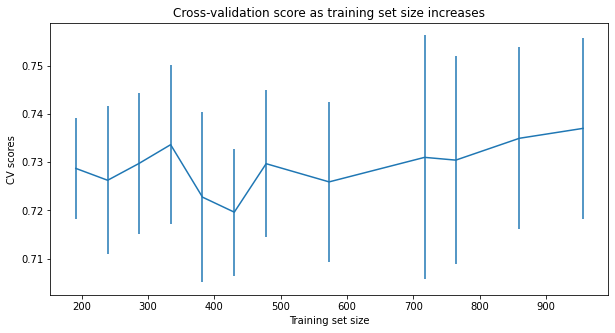

In [663]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

## Save Best Model Object From Pipeline (HistGradient Boosting Regressor Model)

The HistGradient Boosting Regressor turned out to be the best of the four models tested (based on cross-validation RMSE). Below, the best model is saved to be run on the full dataset in a final step ().  

In [298]:
best_model = hgb_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [299]:
# save the model
modelpath = '../models'
save_file(best_model, 'IS1_model_Sat_hgb.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../models\IS1_model_Sat_hgb.pkl"


## Conclusions
